In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score,recall_score





In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load image paths and labels
def load_data_paths_labels(base_dir):
    image_paths, labels = [], []
    for category in ['Normal', 'Non-COVID']:
        category_dir = os.path.join(base_dir, category, 'images')
        for img_name in os.listdir(category_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')) and not img_name.startswith('.'):
                image_paths.append(os.path.join(category_dir, img_name))
                labels.append(0 if category == 'Normal' else 1)
    return image_paths, labels

# Loading data paths and labels
train_image_paths, train_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Train')
val_image_paths, val_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Val')
test_image_paths, test_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Test')

# Convert to DataFrame for flow_from_dataframe
train_df = pd.DataFrame({'filename': train_image_paths, 'category': train_labels})
val_df = pd.DataFrame({'filename': val_image_paths, 'category': val_labels})
test_df = pd.DataFrame({'filename': test_image_paths, 'category': test_labels})

# Convert 'category' to string labels
train_df['category'] = train_df['category'].astype(str)
val_df['category'] = val_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

In [ ]:
def inception_build_model():

  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [ ]:
model = inception_build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    prefetch=2,

)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size
)


checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP/Implemention/resnet_pneumonia_detection.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
callbacks_list = [checkpoint, early_stopping, reduce_lr]

Found 14057 validated image filenames belonging to 2 classes.
Found 3514 validated image filenames belonging to 2 classes.


In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=4,
    max_queue_size=10,
    callbacks=callbacks_list,
    verbose=1

)

Epoch 1/10
440/440 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7136
Epoch 1: val_accuracy improved from -inf to 0.75925, saving model to /content/drive/MyDrive/FYP/Implemention/resnet_pneumonia_detection.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


440/440 [==============================] - 1767s 4s/step - loss: 0.5928 - accuracy: 0.7136 - val_loss: 0.4870 - val_accuracy: 0.7592 - lr: 1.0000e-04
Epoch 2/10
440/440 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7462
Epoch 2: val_accuracy improved from 0.75925 to 0.80820, saving model to /content/drive/MyDrive/FYP/Implemention/resnet_pneumonia_detection.h5
440/440 [==============================] - 252s 570ms/step - loss: 0.5219 - accuracy: 0.7462 - val_loss: 0.4441 - val_accuracy: 0.8082 - lr: 1.0000e-04
Epoch 3/10
440/440 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.7537
Epoch 3: val_accuracy improved from 0.80820 to 0.80990, saving model to /content/drive/MyDrive/FYP/Implemention/resnet_pneumonia_detection.h5
440/440 [==============================] - 255s 575ms/step - loss: 0.5174 - accuracy: 0.7537 - val_loss: 0.4484 - val_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 4/10
440/440 [==============================] - ETA: 0s - loss: 

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)
model_path = '/content/drive/MyDrive/FYP/Implemention/resnet_pneumonia_detection.h5'


loaded_model = tf.keras.models.load_model(model_path)
test_generator.reset()
predictions = loaded_model.predict(test_generator, steps=np.ceil(len(test_df)/batch_size))


binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

Found 4393 validated image filenames belonging to 2 classes.
138/138 [==============================] - 1582s 12s/step


In [ ]:
true_labels = test_generator.classes


accuracy = accuracy_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Accuracy: 0.8076, F1 Score: 0.8076, Precision: 0.8293, Recall: 0.7870


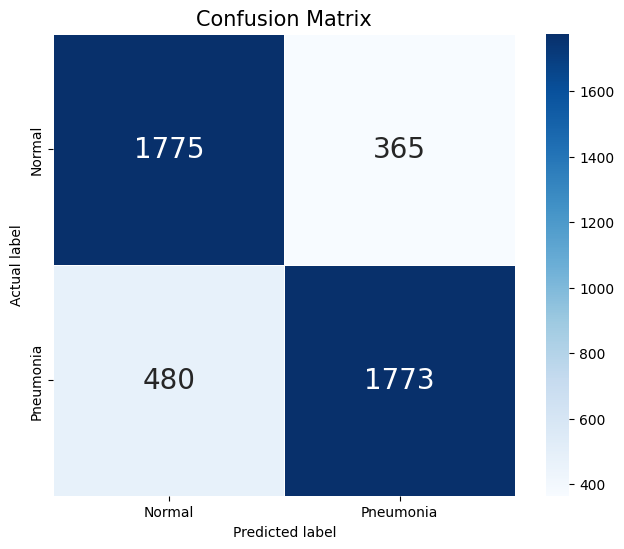

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, class_names):

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', annot_kws={"size": 20},
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size = 15)
    plt.show()

plot_confusion_matrix(true_labels, binary_predictions, ['Normal', 'Pneumonia'])

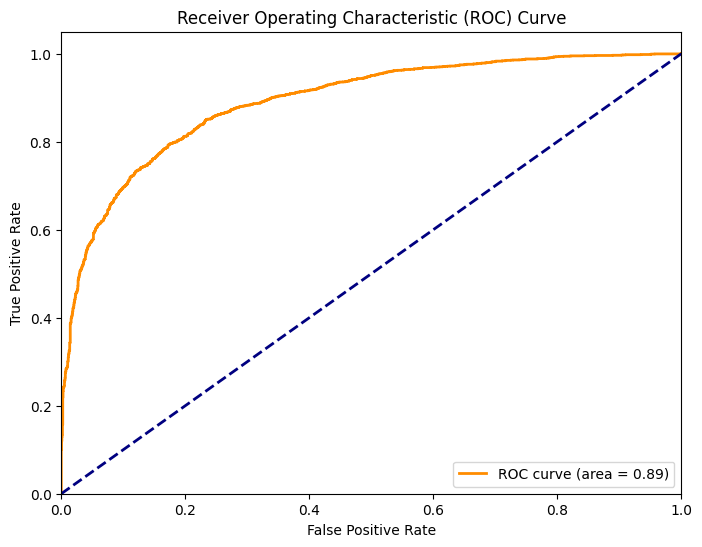

In [ ]:
def plot_roc_curve(true_labels, predictions):

    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(true_labels, predictions.ravel())

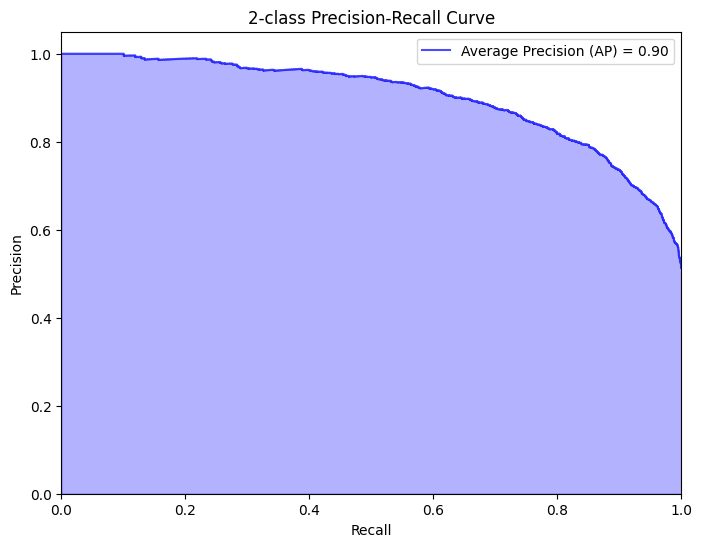

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(true_labels, predictions):

    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    average_precision = average_precision_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7, label=f'Average Precision (AP) = {average_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
plot_precision_recall_curve(true_labels, predictions)

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_training_history(history)